In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [2]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(3,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        #output layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1) #2 classes: 0=not car, 1=car

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        #output layer
        out = self.outconv(xd42)
        return out

In [3]:
model1 = UNetDenoise()
summary(model1, (3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 448, 448]        1,792
├─Conv2d: 1-2                            [-1, 64, 448, 448]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 224, 224]        --
├─Conv2d: 1-4                            [-1, 128, 224, 224]       73,856
├─Conv2d: 1-5                            [-1, 128, 224, 224]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 112, 112]       --
├─Conv2d: 1-7                            [-1, 256, 112, 112]       295,168
├─Conv2d: 1-8                            [-1, 256, 112, 112]       590,080
├─MaxPool2d: 1-9                         [-1, 256, 56, 56]         --
├─Conv2d: 1-10                           [-1, 512, 56, 56]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 56, 56]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 28, 28]         --
├─Conv2d: 1-13                           [-1,

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 448, 448]        1,792
├─Conv2d: 1-2                            [-1, 64, 448, 448]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 224, 224]        --
├─Conv2d: 1-4                            [-1, 128, 224, 224]       73,856
├─Conv2d: 1-5                            [-1, 128, 224, 224]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 112, 112]       --
├─Conv2d: 1-7                            [-1, 256, 112, 112]       295,168
├─Conv2d: 1-8                            [-1, 256, 112, 112]       590,080
├─MaxPool2d: 1-9                         [-1, 256, 56, 56]         --
├─Conv2d: 1-10                           [-1, 512, 56, 56]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 56, 56]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 28, 28]         --
├─Conv2d: 1-13                           [-1,

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #using gpu
#device = torch.device("mps") #for mac gpu accel
print(device)

cuda:0


In [5]:
#dataset processing

In [6]:
#dataLoader to handle mask-image pairs

class SegmentationDataset():
    def __init__(self, testSet=False, transform=None, transformMask=None):
        self.transform = transform
        self.transformMask = transformMask
        if testSet:
            self.image_dir = 'carvanaTest/'
            self.mask_dir = 'carvanaTestMask/'
        else:
            self.image_dir = 'carvanaTrain/'
            self.mask_dir = 'carvanaTrainMask/'
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.gif'))  # Assuming masks have .gif extension
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transformMask(mask)
        #mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

preprocessMask = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
train_datset = SegmentationDataset(testSet=False, transform=preprocess, transformMask=preprocessMask)
test_datset = SegmentationDataset(testSet=True, transform=preprocess, transformMask=preprocessMask)

In [9]:
train_loader = DataLoader(train_datset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=32, shuffle=True)

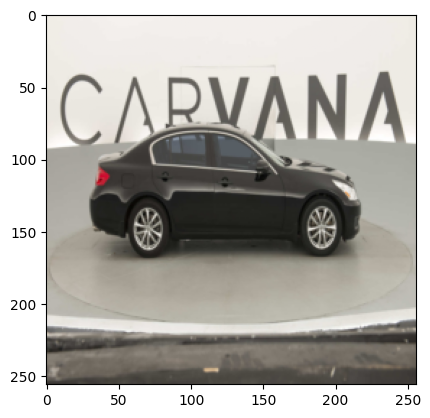

In [10]:
image, mask = train_datset[1]
image = image.permute(1,2,0)
mask = mask.permute(1,2,0)
plt.imshow(image)


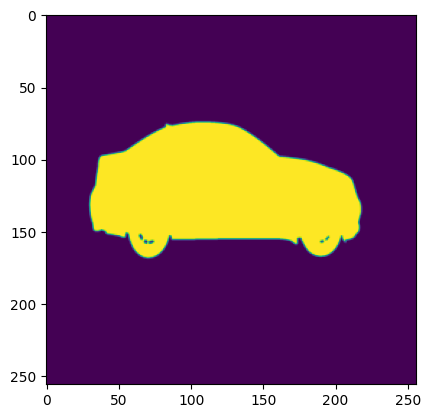

In [11]:
plt.imshow(mask)

In [12]:
min_value = np.min(image.squeeze(0).cpu().numpy())
max_value = np.max(image.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
np.shape(mask)

Minimum value: 0.007843137718737125
Maximum value: 1.0


torch.Size([256, 256, 1])

In [13]:
#Dice score as loss function
class DiceLoss(torch.nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, predicted, target):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice_score = (2 * intersection + self.epsilon) / (union + self.epsilon)
        return 1 - dice_score

In [14]:
optimizer = optim.Adam(model1.parameters(),lr=0.001)
criterion = nn.BCEWithLogitsLoss()
model1.to(device)

UNetDenoise(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv51

In [15]:
for epoch in range(50):
    # Training loop
    model1.train()
    totalLoss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model1(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        totalLoss += loss.item() * images.size(0)
    print(f'epoch {epoch}, loss: {totalLoss/len(train_loader.dataset)}')

epoch 0, loss: 0.709871416091919
epoch 1, loss: 0.5914519143104553
epoch 2, loss: 1.2472887599468232
epoch 3, loss: 0.48631956219673156
epoch 4, loss: 0.48708526372909544
epoch 5, loss: 0.4599427628517151
epoch 6, loss: 0.4341639864444733
epoch 7, loss: 0.4036994564533234
epoch 8, loss: 0.3926741015911102
epoch 9, loss: 0.3832196640968323
epoch 10, loss: 0.3761629354953766
epoch 11, loss: 0.36715909600257873
epoch 12, loss: 0.3583568942546844
epoch 13, loss: 0.35084924697875974
epoch 14, loss: 0.3502668476104736
epoch 15, loss: 0.3411770987510681
epoch 16, loss: 0.3415639913082123
epoch 17, loss: 0.5926833844184876
epoch 18, loss: 0.4734173059463501
epoch 19, loss: 0.6148938751220703
epoch 20, loss: 0.536757698059082
epoch 21, loss: 0.40326696395874023
epoch 22, loss: 0.37914644241333006
epoch 23, loss: 0.43805086731910703
epoch 24, loss: 0.4421719539165497
epoch 25, loss: 0.3975495493412018
epoch 26, loss: 0.36101039409637453
epoch 27, loss: 0.3546747303009033
epoch 28, loss: 0.360639

In [16]:
model1.eval()
losslist=list()
outputs
images
masks
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model1(images)
        loss=criterion(outputs, masks)
        losslist.append(loss)

In [17]:
lossAvg = sum(losslist)/len(losslist)

In [18]:
lossAvg

tensor(0.3437, device='cuda:0')

In [19]:
images_np = images.cpu()
output_np = outputs.cpu()
masks_np = masks.cpu()
anImage = images_np[1].permute(1,2,0)
anMask = masks_np[1].permute(1,2,0)
anOutput = output_np[1]
anOutputChannel = anOutput[0]

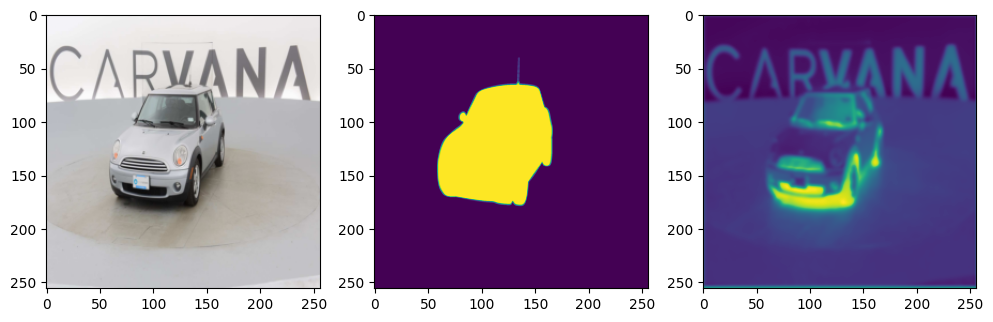

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(anImage)
axes[1].imshow(anMask)
axes[2].imshow(anOutputChannel)

In [21]:
min_value = np.min(anOutputChannel.squeeze(0).cpu().numpy())
max_value = np.max(anOutputChannel.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: -3.0160202980041504
Maximum value: 1.547747015953064


In [22]:
normOutputChannel = (anOutputChannel - min_value) / (max_value - min_value)

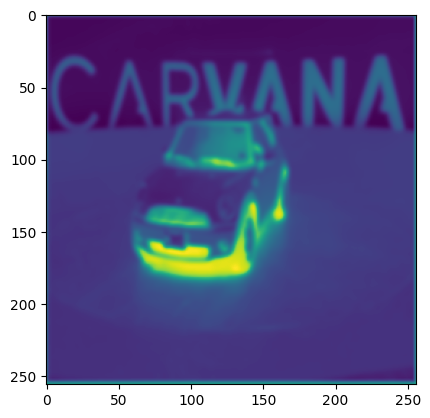

In [23]:
plt.imshow(normOutputChannel)

In [24]:
min_value = np.min(normOutputChannel.squeeze(0).cpu().numpy())
max_value = np.max(normOutputChannel.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: 0.0
Maximum value: 1.0
